In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.special import gamma

warnings.simplefilter("ignore")
plt.style.use("ggplot")

# Oslofjord forestry coefficients

For the Oslofjord forestry project with NIBIO, we will define a set of coefficients representing the effects of forest harvesting on nutrient losses to water courses. These coefficients will be used to multiply the background coefficients derived for TEOTIL3 based on spatial interpolation of the 2019 "1000 Lakes" dataset.

Based on a literature review, Heleen has suggested some typical profiles showing how nutrient concentrations in runoff increase immediately after harvesting, and then decline back to the original level (see e-mail from Heleen received 24.01.2024 at 11.48). This notebook defines two simple functions to represent this behaviour (one linear and one exponential). For each nutrient of interest, both functions require the following inputs (based on literature values):

 1. The maximum factor achieved in year 1 (`factor`), and 
 
 2. The number of years over which harvesting has an effect (`effect_years`).
 
For example, for "high" productivity forest, NO3 concentrations typically increase by a factor of about 10 soon after harvesting, and then decline back to the original levels over a period of about a decade. In this case, the key parameters would be `factor = 10` and `effect_years = 10`. 

**Note:** There is some evidence that the peak in concentrations may be achieved 2 to 4 years after harvesting, rather than immediately in year 1. For this, we might wish to consider e.g. a gamma-like curve, but I haven't looked at this yet.

In [2]:
def fit_linear(factor, effect_years, xmax=10):
    """Generate annual export factors for years from 0 to xmax. In year 0,
    the factor is 1; in year 1 the factor increases to 'factor', then declines
    linearly back to 1 by year 'effect_years'.

    Args
        factor: Int. Maximum facior achieved in year 1.
        effect_years: Int. Duration in years over which effect takes place.
        xmax: Int. Max year to return in 'x_vals'.

    Returns
        Tuple of lists (x_vals, y_vals)
    """
    # Define start and end points
    xs = [1, effect_years]
    ys = [factor, 1]

    # Create interpolation function
    f = interp1d(xs, ys, bounds_error=False, fill_value=1)

    # Generate new x values
    x_vals = list(range(1, xmax + 1))

    # Interpolate y values for new x values
    y_vals = f(x_vals).tolist()

    # Add initial co-ordinates
    x_vals = [0] + x_vals
    y_vals = [1] + y_vals

    return x_vals, y_vals


def fit_exponential(factor, effect_years, xmax=10):
    """Generate annual export factors for years from 0 to xmax. In year 0,
    the factor is 1; in year 1 the factor increases to 'factor', then declines
    exponentially back to 1 by year 'effect_years'.

    Args
        factor: Int. Maximum facior achieved in year 1.
        effect_years: Int. Duration in years over which effect takes place.
        xmax: Int. Max year to return in 'x_vals'.

    Returns
        Tuple of lists (x_vals, y_vals)
    """

    # Define the form of the function we want to fit
    def exp_func(x, A, B):
        return A * np.exp(-B * x)

    # Define start and end points
    xs = [1, effect_years]
    ys = [factor, 1]

    # Use curve_fit to find optimal parameters A and B
    popt, _ = curve_fit(exp_func, xs, ys)

    # Generate new x values
    x_vals = np.arange(1, xmax + 1)

    # Generate corresponding y values
    y_vals = exp_func(x_vals, *popt)
    y_vals[y_vals < 1] = 1

    # Add initial co-ordinates
    x_vals = [0] + x_vals.tolist()
    y_vals = [1] + y_vals.tolist()

    return x_vals, y_vals

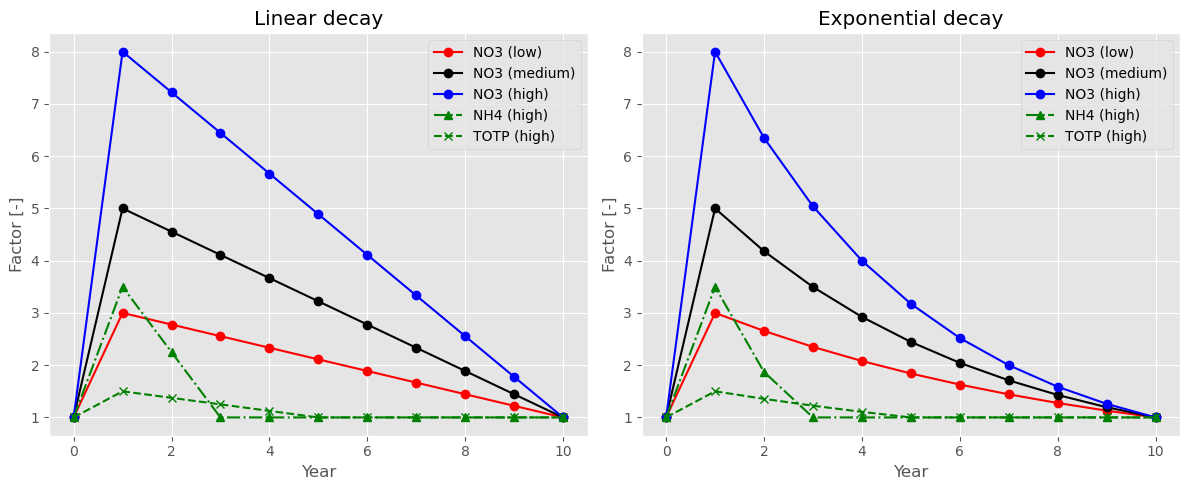

In [3]:
# Example curves for different parameters and bonitet classes
bonitet_dict = {
    "NO3 (low)": (3, 3, 10, "ro-"),
    "NO3 (medium)": (5, 3, 10, "ko-"),
    "NO3 (high)": (8, 3, 10, "bo-"),
    "NH4 (high)": (3.5, 1, 3, "g^-."),
    "TOTP (high)": (1.5, 2, 5, "gx--"),
}

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for bon, (fac, pk_yr, eff_yrs, style) in bonitet_dict.items():
    x_lin, y_lin = fit_linear(fac, eff_yrs)
    x_exp, y_exp = fit_exponential(fac, eff_yrs)

    axes[0].plot(x_lin, y_lin, style, label=bon)
    axes[0].set_ylabel("Factor [-]")
    axes[0].set_xlabel("Year")
    axes[0].set_title("Linear decay")
    axes[0].legend(loc="best")

    axes[1].plot(x_exp, y_exp, style, label=bon)
    axes[1].set_ylabel("Factor [-]")
    axes[1].set_xlabel("Year")
    axes[1].set_title("Exponential decay")
    axes[1].legend(loc="best")

plt.tight_layout()